<a href="https://colab.research.google.com/github/schase15/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Steven_Chase_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [272]:
# Look at dataframe
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [273]:
# Explore the features to decide which ones to include
df.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,87.000000,87.000000,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000,0.0
mean,3.887356,4.167816,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904,NaN
std,0.475396,0.373698,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185,NaN
min,2.500000,2.900000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,NaN
75%,4.000000,4.400000,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,26.000000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [274]:
df.describe(exclude= 'number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,421,421,26,33,7,179,158,154,159,127,92,51,21,21,6,36,35,11,7,7,1,8,38,7,15,17,4,7,2,4,4,1,5,3,3,2,13,3,1,421
unique,5,169,4,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,8/30/2016,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,False
freq,169,29,21,33,5,137,127,114,128,102,67,36,20,17,4,26,27,9,5,4,1,6,33,6,9,9,3,5,2,4,4,1,5,3,3,2,13,2,1,239


In [275]:
# Date is a string, convert it to datetime
df['Date'].dtype

dtype('O')

In [0]:
# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format= True)

In [0]:
# Split data into train, validate and test
# Train is 2016 and earlier
# Validate is 2017
# Test is 2018 and later

train= df[df['Date'] < pd.to_datetime('2017-01-01')]
val= df[(df['Date'] >= pd.to_datetime('2017-01-01')) & (df['Date'] < pd.to_datetime('2018-01-01'))]
test= df[df['Date'] >= pd.to_datetime('2018-01-01')]

Baseline model

In [278]:
## Baselines for train and val
from sklearn.metrics import accuracy_score

# Define target
target= 'Great'

# Set target
y_train= train[target]
y_val= val[target]

# Majority 
majority_class= y_train.mode()[0]

# Target preditions
y_pred_train= [majority_class] * len(y_train)
y_pred_val= [majority_class] * len(y_val)

# Accuracy for baseline model
print('Accuracy score for train:', accuracy_score(y_train, y_pred_train))
print('Accuracy score for val:', accuracy_score(y_val, y_pred_val))

Accuracy score for train: 0.5906040268456376
Accuracy score for val: 0.5529411764705883


First iteration of model

In [0]:
# Set features for train and val
# Set targets already, above

features= ['Cost', 'Temp', 'Fillings']

X_train= train[features]
X_val= val[features]

In [0]:
# Fill in missing values with SimpleImputer
from sklearn.impute import SimpleImputer
imputer= SimpleImputer()

# Transform X_train and X_val
X_train_imputed= imputer.fit_transform(X_train)
X_val_imputed= imputer.transform(X_val)

In [299]:
## First iteration
# Basic logistic regression before encoding data or engineering features

from sklearn.linear_model import LogisticRegression

# Instantiate model
log_reg= LogisticRegression()

# Fit to training data
log_reg.fit(X_train_imputed, y_train)

# Make predictions with val
y_pred= log_reg.predict(X_val_imputed)

# Accuracy score
print('Accuracy score second iteration:', accuracy_score(y_val, y_pred))

Accuracy score second iteration: 0.8352941176470589


Second iteration

In [0]:
# Redefine features and target
# basic features

features= ['Burrito', 'Tortilla', 'Temp', 'Cost', 'Fillings', 'Meat', 'Hunger', 'Uniformity']
target= 'Great'

X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

In [301]:
# Clean the data by doing: One hot encoding, SimpleImputing, StandardScaler

# One hot encoding
import category_encoders as ce

# Instantiate model
encoder= ce.OneHotEncoder(use_cat_names= True)

# Transform X matrices
X_train_encoded= encoder.fit_transform(X_train)
X_val_encoded= encoder.transform(X_val)

# Look at the transformed data
X_train_encoded.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Tortilla,Temp,Cost,Fillings,Meat,Hunger,Uniformity
0,1,0,0,0,0,3.0,5.0,6.49,3.5,3.0,3.0,4.0
1,1,0,0,0,0,2.0,3.5,5.45,2.5,2.5,3.5,4.0
2,0,1,0,0,0,3.0,2.0,4.85,3.0,2.5,1.5,4.0
3,0,0,1,0,0,3.0,2.0,5.25,3.0,3.5,2.0,5.0
4,1,0,0,0,0,4.0,5.0,6.59,3.5,4.0,4.0,5.0


In [0]:
# SimpleImputing - Fill in NaN values

# Instantiate model
imputer= SimpleImputer()

# Transform X matrices
X_train_imputed= imputer.fit_transform(X_train_encoded)
X_val_imputed= imputer.transform(X_val_encoded)

In [0]:
# Standard scaler
from sklearn.preprocessing import StandardScaler

# Instantiate model
scaler= StandardScaler()

# Transform X matrices
X_train_scaled= scaler.fit_transform(X_train_imputed)
X_val_scaled= scaler.transform(X_val_imputed)

In [304]:
# Fit model with cleaned data
from sklearn.linear_model import LogisticRegressionCV

# Instantiate model
model= LogisticRegressionCV()

# Fit
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [313]:
# Look at the models coefficients
pd.Series(model.coef_[0], X_train_encoded.columns)

Burrito_California     0.154781
Burrito_Carnitas       0.012879
Burrito_Asada          0.037321
Burrito_Other         -0.126486
Burrito_Surf & Turf   -0.114870
Tortilla               0.370157
Temp                   0.274858
Cost                   0.192945
Fillings               0.741202
Meat                   0.726159
Hunger                 0.130901
Uniformity             0.394704
dtype: float64

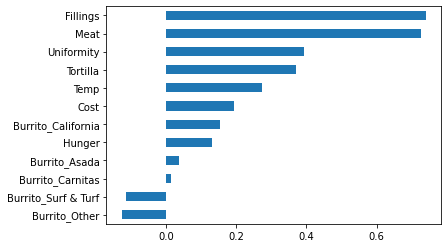

In [312]:
# Visual comparision of scaled coefficients 

%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

In [305]:
# Look at the new accuracy score after cleaning data

# Make predictions with val
y_pred= model.predict(X_val_scaled)

# Accuracy score
print('Accuracy score second iteration:', accuracy_score(y_val, y_pred))

Accuracy score second iteration: 0.8588235294117647


In [306]:
# Test model once at the very end when you are done tweaking using train and val
# How have to do the same workflow we did on the train and val data

# Set features
X_test = test[features]
y_test = test[target]

# Encode
X_test_encoded = encoder.transform(X_test)

# Impute
X_test_imputed = imputer.transform(X_test_encoded)

# Standard scaled
X_test_scaled = scaler.transform(X_test_imputed)

# Make predictions with cleaned test
y_pred = model.predict(X_test_scaled)

# Final accuracy score of test
print('Accuracy score final test:', accuracy_score(y_test, y_pred))

Accuracy score final test: 0.7631578947368421


In [0]:
##### DIDN'T FINISH WHAT I WAS WORKING ON BELOW. STOPPED TO STUDY FOR THE SPRINT CHALLENGE

In [0]:
## will most likely finish later when I have the time

# Clean all data and create model with more features

Third iteration- data cleaning to use most all features

## Clean Data

In [0]:
# Replace numeric NaN with means
# Replace categorical NaN with modes

In [340]:
# Look at queso which should be categorical not numeric

df['Queso'].isnull().sum()

KeyError: ignored

In [0]:
# Drop queso column because it is 100% NaN values
df= df.drop('Queso', axis= 1)

In [341]:
# Pull out numeric column headers and save to new df
numeric= df.describe()
numeric = numeric.columns.values.tolist()
df_numeric = df[numeric]
df_numeric.head()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,3.5,4.2,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0
1,3.5,3.3,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0
2,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0
3,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0
4,4.0,3.8,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0


In [342]:
# Drop Yelp, Google and Synergy because it will cause data leakage
df_numeric= df_numeric.drop(['Yelp', 'Google', 'Synergy'], axis=1)
df_numeric.head()

,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Wrap
0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0
1,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,5.0
2,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,5.0
3,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,5.0
4,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.0


In [343]:
# For columns Mass, Density, Length, Circum, and volume there are not enough data points.
# We would be filling 95% of mass and density, and filling over 50% for length, circum and volume

df_numeric = df_numeric.drop(['Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume'], axis= 1)
df_numeric

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Wrap
0,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0
1,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,5.0
2,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,5.0
3,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,5.0
4,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.0
...,...,...,...,...,...,...,...,...,...,...
418,6.00,1.0,5.0,4.0,3.5,NaN,4.0,4.0,2.0,5.0
419,6.00,4.0,4.0,5.0,NaN,3.5,4.0,4.0,5.0,3.0
420,7.90,3.0,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.5
421,7.90,3.0,5.0,2.0,5.0,5.0,5.0,2.0,5.0,2.0


In [347]:
# Look at how many null values
df_numeric.isnull().sum()

Cost            0
Hunger          0
Tortilla        0
Temp            0
Meat            0
Fillings        0
Meat:filling    0
Uniformity      0
Salsa           0
Wrap            0
dtype: int64

In [0]:
# Replace null values with mean
imputer= SimpleImputer()
# imputer.fit(df_numeric)
df_numeric_imputed = imputer.fit_transform(df_numeric)

In [346]:
# Convert back to dataframe
column_headers= df_numeric.columns.values.tolist()

df_numeric = pd.DataFrame(df_numeric_imputed, columns= column_headers)
df_numeric

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Wrap
0,6.49,3.0,3.0,5.0,3.000000,3.500000,4.0,4.0,4.0,4.0
1,5.45,3.5,2.0,3.5,2.500000,2.500000,2.0,4.0,3.5,5.0
2,4.85,1.5,3.0,2.0,2.500000,3.000000,4.5,4.0,3.0,5.0
3,5.25,2.0,3.0,2.0,3.500000,3.000000,4.0,5.0,4.0,5.0
4,6.59,4.0,4.0,5.0,4.000000,3.500000,4.5,5.0,2.5,4.0
...,...,...,...,...,...,...,...,...,...,...
416,6.00,1.0,5.0,4.0,3.500000,3.539833,4.0,4.0,2.0,5.0
417,6.00,4.0,4.0,5.0,3.620393,3.500000,4.0,4.0,5.0,3.0
418,7.90,3.0,4.0,4.0,4.000000,3.700000,3.0,2.0,3.5,4.5
419,7.90,3.0,5.0,2.0,5.000000,5.000000,5.0,2.0,5.0,2.0


In [351]:
# Do the same thing for categorical but replace them with modes
# Pull out categorical columns and save to new dataframe

categorical= df.describe(exclude= 'number')
categorical = categorical.columns.values.tolist()
df_categorical = df[categorical]
df_categorical.shape

(421, 40)

In [352]:
# Drop Unreliable, NonSD, Chips, Date, 
df_categorical= df_categorical.drop(['Unreliable', 'NonSD', 'Chips'], axis= 1)
df_categorical

,Burrito,Date,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Other,2019-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
419,Other,2019-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
420,California,2019-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
421,Other,2019-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [354]:
# Replace x and X with 1, NaN with 0
df_categorical= df_categorical.replace({'x': 'True', 'X': 'False', np.NaN: 'False'})
df_categorical

,Burrito,Date,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,California,2016-01-24,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Carnitas,2016-01-24,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Asada,2016-01-24,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,California,2016-01-27,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Other,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
419,Other,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
420,California,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
421,Other,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [355]:
# Add dataframes back together now that they are cleaned. 
df_clean= pd.concat([df_numeric, df_categorical], axis= 1)
df_clean

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Wrap,Burrito,Date,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,California,2016-01-18,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,5.0,California,2016-01-24,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,5.0,Carnitas,2016-01-24,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,5.0,Asada,2016-01-24,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.0,California,2016-01-27,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,7.90,3.0,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.5,Other,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
419,7.90,3.0,5.0,2.0,5.0,5.0,5.0,2.0,5.0,2.0,Other,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
420,5.50,3.5,3.0,5.0,4.3,4.0,4.9,3.8,3.0,4.0,California,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [0]:
# Added two new rows, drop them
df_clean = df_clean.drop([421, 422])

In [359]:
df_clean

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Wrap,Burrito,Date,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,6.49,3.0,3.0,5.0,3.000000,3.500000,4.0,4.0,4.0,4.0,California,2016-01-18,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,5.45,3.5,2.0,3.5,2.500000,2.500000,2.0,4.0,3.5,5.0,California,2016-01-24,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,4.85,1.5,3.0,2.0,2.500000,3.000000,4.5,4.0,3.0,5.0,Carnitas,2016-01-24,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,5.25,2.0,3.0,2.0,3.500000,3.000000,4.0,5.0,4.0,5.0,Asada,2016-01-24,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,6.59,4.0,4.0,5.0,4.000000,3.500000,4.5,5.0,2.5,4.0,California,2016-01-27,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,6.00,1.0,5.0,4.0,3.500000,3.539833,4.0,4.0,2.0,5.0,Other,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
417,6.00,4.0,4.0,5.0,3.620393,3.500000,4.0,4.0,5.0,3.0,California,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
418,7.90,3.0,4.0,4.0,4.000000,3.700000,3.0,2.0,3.5,4.5,Other,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
419,7.90,3.0,5.0,2.0,5.000000,5.000000,5.0,2.0,5.0,2.0,Other,2019-08-27,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


## Use cleaned data for third iteration of model

In [0]:
# Use new clean data
# Set train, test, val

# Convert to datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], infer_datetime_format= True)

# Split data into train, validate and test
# Train is 2016 and earlier
# Validate is 2017
# Test is 2018 and later

train= df_clean[df_clean['Date'] < pd.to_datetime('2017-01-01')]
val= df_clean[(df_clean['Date'] >= pd.to_datetime('2017-01-01')) & (df_clean['Date'] < pd.to_datetime('2018-01-01'))]
test= df_clean[df_clean['Date'] >= pd.to_datetime('2018-01-01')]

In [0]:
# Set features and target

target= 'Great'
features= df_clean.columns.drop(['Great', 'Date'])

X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

X_test= [features]
y_test= [target]

In [362]:
# One hot encoding
import category_encoders as ce

# Instantiate model
encoder= ce.OneHotEncoder(use_cat_names= True)

# Transform X matrices
X_train_encoded= encoder.fit_transform(X_train)
X_val_encoded= encoder.transform(X_val)

# Look at the transformed data
X_train_encoded.head()

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Wrap,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Beef_True,Beef_False,Pico_True,Pico_False,Guac_True,Guac_False,Cheese_True,Cheese_False,Fries_True,Fries_False,Sour cream_False,Sour cream_True,Pork_False,Pork_True,Chicken_False,Chicken_True,Shrimp_False,Shrimp_True,Fish_False,Fish_True,Rice_False,Rice_True,Beans_False,Beans_True,Lettuce_False,...,Bell peper_False,Bell peper_True,Carrots_False,Carrots_True,Cabbage_False,Cabbage_True,Sauce_False,Sauce_True,Salsa.1_False,Salsa.1_True,Cilantro_False,Cilantro_True,Onion_False,Onion_True,Taquito_False,Taquito_True,Pineapple_False,Pineapple_True,Ham_False,Ham_True,Chile relleno_False,Chile relleno_True,Nopales_False,Nopales_True,Lobster_False,Lobster_True,Egg_False,Egg_True,Mushroom_False,Mushroom_True,Bacon_False,Bacon_True,Sushi_False,Sushi_True,Avocado_False,Avocado_True,Corn_False,Corn_True,Zucchini_False,Zucchini_True
0,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
1,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,5.0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
2,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,5.0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
3,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,5.0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
4,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0


In [0]:
# Fill in NaN values on newest encoded train and val data set

imputer = SimpleImputer(strategy= 'mean')
X_train_imputed= imputer.fit_transform(X_train_encoded)
X_val_imputed= imputer.transform(X_val_encoded)

In [0]:
# Standard scaler
from sklearn.preprocessing import StandardScaler

# Instantiate model
scaler= StandardScaler()

# Transform X matrices
X_train_scaled= scaler.fit_transform(X_train_imputed)
X_val_scaled= scaler.transform(X_val_imputed)

In [0]:
# # Fit model with cleaned data
# from sklearn.linear_model import LogisticRegressionCV

# # Instantiate model
# model= LogisticRegressionCV()

# # Fit
# model.fit(X_train_scaled, y_train)